# Preamble

In [ ]:
import $ivy.`org.http4s::http4s-ember-client:0.23.23`
import $ivy.`org.http4s::http4s-dsl:0.23.23`
import $ivy.`org.http4s::http4s-circe:1.0.0-M40`
import $ivy.`co.fs2::fs2-core:3.8.0`
import $ivy.`co.fs2::fs2-io:3.8.0`
import $ivy.`io.circe::circe-parser:0.15.0-M1`
import $ivy.`io.circe::circe-generic:0.15.0-M1`
import $ivy.`org.slf4j:slf4j-nop:2.0.9`
import $ivy.`io.circe::circe-optics:0.15.0`
import $ivy.`dev.optics::monocle-macro:3.2.0`

In [ ]:
import fs2.{Pipe, Pull, Stream}
import cats.effect.{IO, Async}
import cats.effect.unsafe.implicits.global
import org.http4s.*, org.http4s.implicits._
import io.circe.Json
import io.circe.{`export` as _, Json, *}
import io.circe.parser._
import io.circe.syntax._
import io.circe.optics.JsonPath._

In [ ]:
import fs2.{Pipe, Pull, Stream}
import cats.effect.{IO, Async}
import cats.effect.unsafe.implicits.global
import org.http4s.*, org.http4s.implicits._
import io.circe.Json
import io.circe.{`export` as _, Json, *}
import io.circe.parser._
import io.circe.syntax._
import io.circe.optics.JsonPath._

In [ ]:
object IsArray: 
    def unapply(v: Json): Option[Vector[Json]] = 
        v.asArray

In [ ]:
object IsObject: 
    def unapply(v: Json): Option[JsonObject] = 
        v.asObject

In [ ]:
object IsString: 
    def unapply(v: Json): Option[String] = 
        v.asString

In [ ]:
def stream[F[_]: cats.effect.kernel.Async](u: org.http4s.Uri): Stream[F, Json] = 
    import org.http4s.ember.client.EmberClientBuilder
    import io.circe.jawn.CirceSupportParser
    import org.http4s.headers.Authorization
    import org.http4s.{Method, Request}
    import org.typelevel.jawn.Facade
    import org.typelevel.jawn.fs2._

    given Facade[Json] = new CirceSupportParser(None, false).facade
    val bearerToken = scala.util.Properties.envOrElse("BEARER_GITHUB_TOKEN", "undefined")
    val authHeader =  Authorization(Credentials.Token(AuthScheme.Bearer, bearerToken))
    Stream.resource(EmberClientBuilder.default[F].build).flatMap{
        _.stream(Request[F](Method.GET, u).withHeaders(authHeader))
         .flatMap(_.body.chunks.parseJsonStream)
    }

In [ ]:
extension [A](st: Stream[IO, A])
    def run: List[A] = 
        st.compile.toList.unsafeRunSync()

In [ ]:
def allCommitPages[F[_]: Async](repo: String): Stream[F, Json] =

    def newPage(i: Int): Stream[F, Json] = 
        stream(Uri.unsafeFromString(s"$repo/commits?page=$i"))
    
    def go(i: Int, s: Stream[F,Json]): Pull[F, Json, Unit] =
        s.pull.uncons.flatMap:
            case Some((hd,tl)) =>
                hd(0) match
                    case IsArray(Vector()) => Pull.done
                    case _ => Pull.output(hd) >> go(i+1, tl ++ newPage(i))
            case None => Pull.done

    go(1, newPage(0)).stream

# How to embed `jq`? 

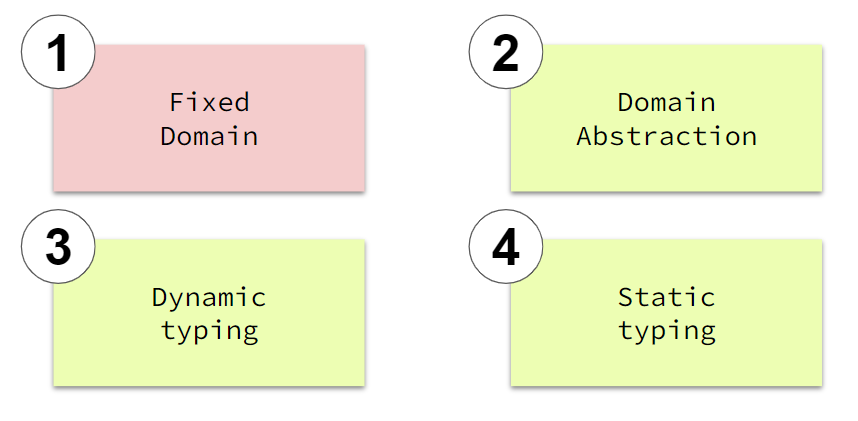

### Ad-hoc implementation

In [ ]:
class Fs2_Jq[F[_]]: 

    type Filter = fs2.Pipe[F, Json, Json]

    def iterator: Filter = 
        _ flatMap: 
            case IsArray(v) => Stream(v*)
            case _ => Stream(Json.Null)

    extension (f1: Filter)

        def |(f2: Filter): Filter = 
            _ flatMap: json => 
                f1(Stream(json)).flatMap: json2 => 
                    f2(Stream(json2)) 

    def arr(filters: Filter*): Filter = 

        def concat(f1: Filter, f2: Filter): Filter = 
            _.flatMap: json => 
                f1(Stream(json)) ++ f2(Stream(json))

        _ flatMap: json => 
            filters.reduce(concat)(Stream(json))
                .fold(List[Json]())(_ :+ _)
                .map(Json.arr(_*))

    extension (sc: StringContext)

        private def index0(k: String): Filter =
            _ map:
                case IsObject(obj) => obj(k).getOrElse(Json.Null)
                case _ => Json.Null

        def i(args: Filter*): Filter = 
            sc.s().split('.').map(index0).reduce(_ | _)

In [ ]:
def extractInfo[F[_]]: Pipe[F, Json, Json] = 
    val Fs2_Jq_F = Fs2_Jq[F]; import Fs2_Jq_F._
    iterator | arr(i"author.login", i"commit.author.date")

In [ ]:
val commitInfoResults: List[Json] = 
    allCommitPages[IO]("https://api.github.com/repos/hablapps/doric")
        .take(2)
        .through(extractInfo)
        .run

### Deep vs. surface syntax

In [ ]:
class Fs2_Jq[F[_]]: 

    type Filter = Pipe[F, Json, Json]

    /* Primitive filters */

    def id: Filter = 
        identity[Stream[F, Json]]

    def str(s: String): Filter = 
        _.map(_ => Json.fromString(s))

    def iterator: Filter = 
        _ flatMap: 
            case IsArray(v) => Stream(v*)
            case _ => Stream(Json.Null)

    extension (f1: Filter)

        def |(f2: Filter): Filter = 
            _ flatMap: json => 
                f1(Stream(json)).flatMap: json2 => 
                    f2(Stream(json2)) 

        def concat(f2: Filter): Filter = 
            _ flatMap: json => 
                f1(Stream(json)) ++ f2(Stream(json))

        private def indexObj(key: String)(v: Json): Stream[F, Json] = 
            f1(Stream(v)) map:
                case IsObject(obj) => obj(key).getOrElse(Json.Null)
                case _ => Json.Null

        def index(f2: Filter): Filter = 
            _ flatMap: v => 
                f2(Stream(v)) flatMap:
                    case IsString(s) => indexObj(s)(v)
                    case _ => Stream(Json.Null)

    def array(f: Filter): Filter = 
        _ flatMap: json => 
            f(Stream(json))
                .fold(List[Json]())(_ :+ _)
                .map(Json.arr(_*))

    /* Syntactic sugar */

    def arr(f: Filter*): Filter = 
        array(f.reduce(_ concat _))

    extension (sc: StringContext)
        def i(args: Filter*): Filter = 
            sc.s().split('.').map(key => id.index(str(key))).reduce(_ | _)

In [ ]:
def extractInfo[F[_]]: Pipe[F, Json, Json] = 
    val Fs2_Jq_F = Fs2_Jq[F]; import Fs2_Jq_F._
    iterator | arr(i"author.login", i"commit.author.date")

In [ ]:
val commitInfoResults: List[Json] = 
    allCommitPages[IO]("https://api.github.com/repos/hablapps/doric")
        .take(2)
        .through(extractInfo)
        .run

### Built-in functions

In [ ]:
class Fs2_Jq[F[_]]: 

    type Filter = Pipe[F, Json, Json]

    /* Primitive filters */

    def id: Filter = 
        identity[Stream[F, Json]]

    def str(s: String): Filter = 
        _.map(_ => Json.fromString(s))

    def iterator: Filter = 
        _ flatMap: 
            case IsArray(v) => Stream(v*)
            case _ => Stream(Json.Null)

    extension (f1: Filter)

        def |(f2: Filter): Filter = 
            _ flatMap: json => 
                f1(Stream(json)).flatMap: json2 => 
                    f2(Stream(json2)) 

        def concat(f2: Filter): Filter = 
            _ flatMap: json => 
                f1(Stream(json)) ++ f2(Stream(json))

        private def indexObj(key: String)(v: Json): Stream[F, Json] = 
            f1(Stream(v)) map:
                case IsObject(obj) => obj(key).getOrElse(Json.Null)
                case _ => Json.Null

        def index(f2: Filter): Filter = 
            _ flatMap: v => 
                f2(Stream(v)) flatMap:
                    case IsString(s) => indexObj(s)(v)
                    case _ => Stream(Json.Null)

    def array(f: Filter): Filter = 
        _ flatMap: json => 
            f(Stream(json))
                .fold(List[Json]())(_ :+ _)
                .map(Json.arr(_*))

    /* derived functions */

    def map(f: Filter): Filter = 
        array(iterator | f)
    
    /* 
    def map_adhoc(f: Filter): Filter = 
        _ flatMap { 
            case j if j.isArray => 
                Stream(j.asArray.get:_*)
                    .flatMap{ j => f(Stream(j)) }
                    .fold(List[Json]())(_ :+ _)
                    .map(Json.arr(_:_*))
            case _ => Stream()
        }
    */

    /* Syntactic sugar */

    def arr(f: Filter*): Filter = 
        array(f.reduce(_ concat _))

    extension (sc: StringContext)
        def i(args: Filter*): Filter = 
            sc.s().split('.').map(key => id.index(str(key))).reduce(_ | _)

In [ ]:
def test[F[_]: cats.effect.Async] = 
    val Fs2_Jq_F = Fs2_Jq[F]; import Fs2_Jq_F._
    commitsStr[F].through(map(i"author.login"))

### What if we want another semantics, e.g. akka stream?

We have to repeat a lot of things: namely, the signatures of the primitive functions, the derived combinators, the syntactic sugar ... 

In [ ]:
import $ivy.`com.typesafe.akka::akka-stream:2.8.5`

In [ ]:
import akka.stream._
import akka.stream.scaladsl._
import akka.{ Done, NotUsed }

In [ ]:
object Akka_Jq: 

    type Filter = Flow[Json, Json, akka.NotUsed]

    /* Primitive filters */

    def id: Filter = 
        Flow[Json]

    def str(s: String): Filter = 
        Flow.fromFunction(_ => Json.fromString(s))

    def iterator: Filter = 
        ???

    extension (f1: Filter)

        def |(f2: Filter): Filter = 
            ???

        def concat(f2: Filter): Filter = 
            ???

        private def indexObj(key: String)(v: Json): Stream[IO, Json] = 
            ???

        def index(f2: Filter): Filter = 
            ???

    def array(f: Filter): Filter = 
        ???

    /* derived functions */

    def map(f: Filter): Filter = 
        array(iterator | f)
    
    /* Syntactic sugar */

    def arr(f: Filter*): Filter = 
        array(f.reduce(_ concat _))

    extension (sc: StringContext)
        def i(args: Filter*): Filter = 
            sc.s().split('.').map(key => id.index(str(key))).reduce(_ | _)

Also programs are the same: 

In [ ]:
def extractAuthorInfo: Akka_Jq.Filter = 
    import Akka_Jq._
    iterator | arr(i"author.login", i"commit.author.date")

# References

* Scala 3 extension methods: https://docs.scala-lang.org/scala3/book/ca-extension-methods.html
* Conversion type class: https://docs.scala-lang.org/scala3/reference/contextual/conversions.html